In [1]:
MARGIN=1.3
LEARNING_RATE=0.0005

## Import Libraries

In [2]:
import numpy as np
from sklearn.metrics import roc_curve
from sklearn.neighbors import KNeighborsClassifier
import random
import matplotlib.patheffects as PathEffects
import sys
sys.path
sys.executable

'/home/ubuntu/anaconda3/envs/triplet36/bin/python'

In [3]:
from keras.layers import Input, Conv2D, Lambda, Dense, Flatten,MaxPooling2D, concatenate
from keras.models import Model, Sequential
from keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping
from keras.regularizers import l2
from keras import backend as K
from keras.optimizers import SGD,Adam
from keras.losses import binary_crossentropy
from keras import regularizers
import os
import pickle
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [4]:
from itertools import permutations
import seaborn as sns
from keras.datasets import mnist
from sklearn.manifold import TSNE
from sklearn.svm import SVC

In [5]:
import cv2
import os
import numpy as np
from PIL import Image
import shutil

## Check Image 

In [43]:
# Define our own plot function
def scatter(x, labels, num_of_labels, subtitle=None):
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", num_of_labels))

    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    
    
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40,
                    c=palette[labels.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    # 그래프 규격선, 여백공간 제거
    ax.axis('off') 
    ax.axis('tight')

    # We add the labels for each digit.
    txts = []
    for i in range(num_of_labels):
        # Add Label with txt type on plotting image
        xtext, ytext = np.median(x[labels == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)
        
    if subtitle != None:
        plt.suptitle(subtitle)
        
    plt.savefig(subtitle)
    
def checkImgSet(msg, x_sample, y_sample, filename_sample, classes, maxnum):

    print(msg)
    for k in range(classes):
        plt.figure(figsize=(20,20))
    
        num=0
        for i in range(len(y_sample)):
            if num==maxnum:
                break
            if y_sample[i]==k:
                num+=1
                plt.subplot(10,10,num)
                plt.xticks([])
                plt.yticks([])
                plt.grid(False)
                plt.imshow(x_sample[i], cmap='gray', vmin=0, vmax=255)
                #plt.imshow(cv2.cvtColor(x_sample[i], cv2.COLOR_BGR2RGB))
                plt.xlabel(str(y_sample[i])+filename_sample[i][25:-10])
        plt.show()
        
def checkTripletImgSet(msg, triplet_sample, maxnum):

    print(msg)
    plt.figure(figsize=(15,15*maxnum))
    for i in range(min(maxnum, len(triplet_sample))):
        for j in range(3):
            plt.subplot(5*maxnum, 3,i*3+j+1)
            plt.xticks([])
            plt.yticks([])
            plt.grid(False)
            plt.imshow(triplet_sample[i][j].reshape(28,28), cmap='gray', vmin=0, vmax=255)
            #plt.imshow(cv2.cvtColor(triplet_sample[i][j].reshape(28,28), cv2.COLOR_BGR2RGB))
    plt.show()
    


## Shuffle and Reload Yoga Data

In [44]:
def divide_data(path, row, column, channel):
    x_train=[]
    y_train=[]
    x_test=[]
    y_test=[]
    
    # Get directory has yoga poses
    DataPaths = [path+'/'+folder_name for folder_name in os.listdir(path)]
    
    # Check each image folders. each image folder contains images with same yoga posture 
    for label_idx in range(len(DataPaths)):
        LabelPath = DataPaths[label_idx]
        
        ImgNames = [image_name for image_name in os.listdir(LabelPath+'/every/total')]
   
        for img_idx in range(len(ImgNames)):
            path_from = LabelPath+'/every/total/'+ImgNames[img_idx]
            if img_idx%7 == 0:
                path_to = LabelPath+'/test/'+ImgNames[img_idx]
            else:
                path_to = LabelPath+'/train/'+ImgNames[img_idx]
            print(path_to)
            print(path_from)
            shutil.move(path_from, path_to)


In [45]:
def shuffle(x_total, y_total, filename_total, shuffled_idx_path):
    idxs = np.arange(x_total.shape[0])
    np.random.shuffle(idxs)
    
    # save shuffle data. next time reload this shuffed pattern
    np.savetxt(shuffled_idx_path, idxs, delimiter=",")
    
    shuffled_filename_total=[]
    shuffled_x_total=[]
    shuffled_y_total=[]
    for idx in range(len(filename_total)):
        shuffled_filename_total.append(filename_total[idxs[idx]])
        shuffled_x_total.append(x_total[idxs[idx]])
        shuffled_y_total.append(y_total[idxs[idx]])
    
    return np.array(shuffled_x_total), np.array(shuffled_y_total), np.array(shuffled_filename_total)
    #return x_total[idxs], y_total[idxs], shuffled_filename_total

def reshuffle(x_total, y_total, filename_total, shuffled_idx_path):
    load_idxs = np.loadtxt(fname=shuffled_idx_path, delimiter=',')
    idxs=np.array(load_idxs)
    
    shuffled_filename_total=[]
    shuffled_x_total=[]
    shuffled_y_total=[]
    for idx in range(len(filename_total)):
        shuffled_filename_total.append(filename_total[idxs[idx]])
        shuffled_x_total.append(x_total[idxs[idx]])
        shuffled_y_total.append(y_total[idxs[idx]])
    
    return np.array(shuffled_x_total), np.array(shuffled_y_total), np.array(shuffled_filename_total)
    #return x_total[idxs], y_total[idxs], shuffled_filename_total

In [46]:
def load_data(path, row, column, channel):
    x_train=[]
    y_train=[]
    filename_train=[]
    x_test=[]
    y_test=[]
    filename_test=[]
    # Get directory has yoga poses
    DataPaths = [path+'/'+folder_name for folder_name in os.listdir(path)]
    
    # Check each image folders. each image folder contains images with same yoga posture 
    for label_idx in range(len(DataPaths)):
        LabelPath = DataPaths[label_idx]
        
        # Check each kinds of data. Training samples and Validation samples
        sample_kind=['/train/', '/test/']
        for k in range(2):
            ImgPaths = [LabelPath+sample_kind[k]+image_name for image_name in os.listdir(LabelPath+sample_kind[k])]

            for idx in range(len(ImgPaths)):
                imagePath = ImgPaths[idx]

                img = cv2.imread(imagePath, cv2.IMREAD_COLOR)

                if channel==1:
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

                img = cv2.resize(img, (row,column), interpolation = cv2.INTER_AREA)
                
                if k==0:
                    x_train.append(img)
                    y_train.append(label_idx)
                    filename_train.append(imagePath)
                else:    
                    x_test.append(img)
                    y_test.append(label_idx)
                    filename_test.append(imagePath)
              
        
    return np.array(x_train), np.array(y_train), filename_train, np.array(x_test), np.array(y_test), filename_test

### load data

In [47]:
img_row=28
img_column=28
img_channel=1

#divide_data('../../../Desktop/DL/DB_images/yoga/data',img_row, img_column, img_channel)
x_train, y_train, filename_train, x_test, y_test, filename_test = load_data('../../data',img_row, img_column, img_channel)
x_total = np.array(np.concatenate((x_train, x_test), axis = 0))
y_total = np.array(np.concatenate((y_train, y_test), axis = 0))
filename_total = np.concatenate((filename_train, filename_test), axis = 0)

In [48]:
print(x_train.shape, x_test.shape, x_total.shape)

(1408, 28, 28) (237, 28, 28) (1645, 28, 28)


### shuffle

In [49]:
x_train, y_train, filename_train = shuffle(x_train, y_train, filename_train, "shuffle_train.csv")
x_test, y_test, filename_test = shuffle(x_test, y_test, filename_test, "shuffle_test.csv")
x_total, y_total, filename_total = shuffle(x_total, y_total, filename_total, "shuffle_total.csv")

### flatten

In [50]:
x_train_flat = x_train.reshape(-1,img_row*img_column*img_channel)
x_test_flat = x_test.reshape(-1,img_row*img_column*img_channel)                           
x_total_flat = x_total.reshape(-1,img_row*img_column*img_channel)

'''
print(x_train.shape, x_test.shape, x_total.shape)
print(y_train.shape, y_test.shape, y_total.shape)
print(len(filename_train), len(filename_test), len(filename_total))
print(filename_test[0], filename_total[len(filename_train)])
'''

'\nprint(x_train.shape, x_test.shape, x_total.shape)\nprint(y_train.shape, y_test.shape, y_total.shape)\nprint(len(filename_train), len(filename_test), len(filename_total))\nprint(filename_test[0], filename_total[len(filename_train)])\n'

## Divide Data for training and validation

Training Samples


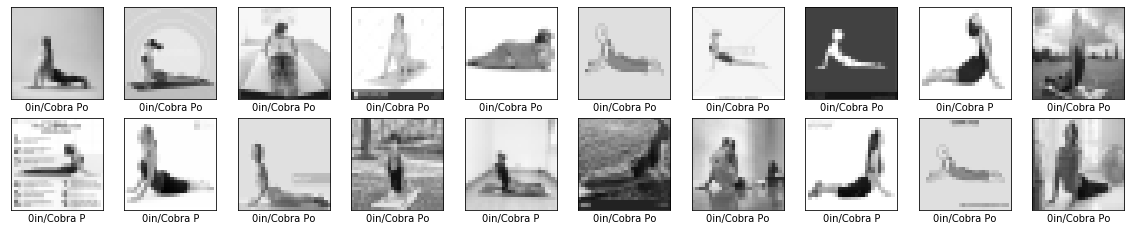

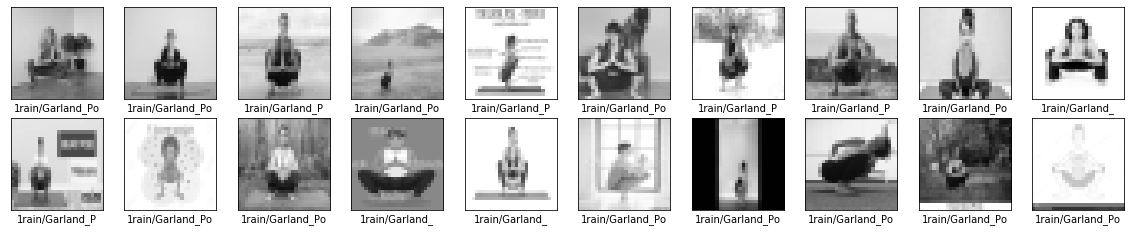

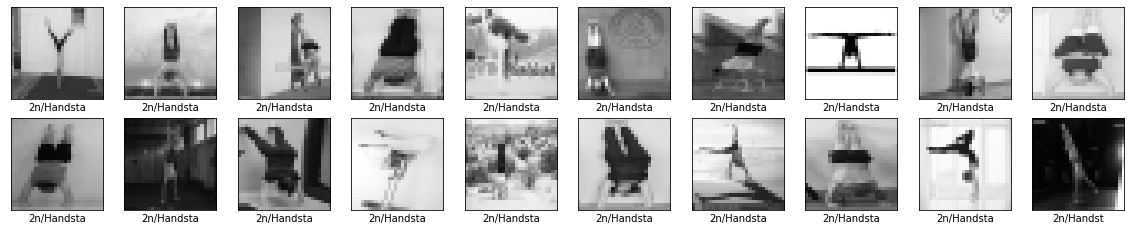

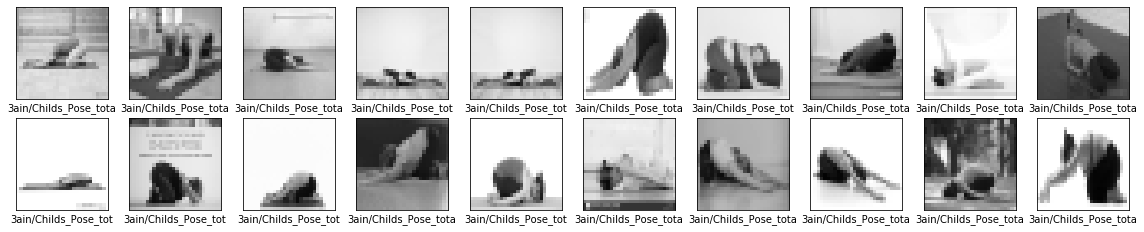

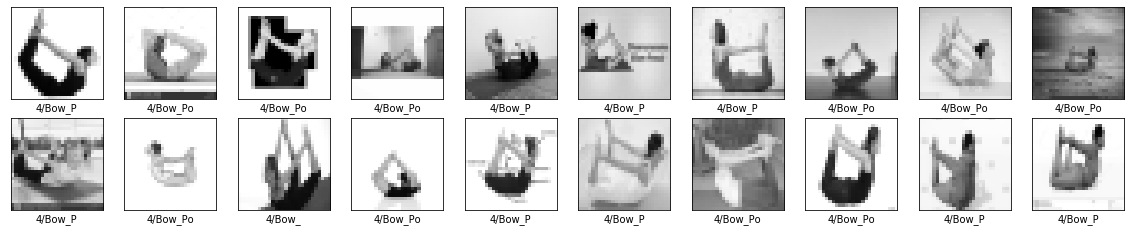

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

Validation Samples


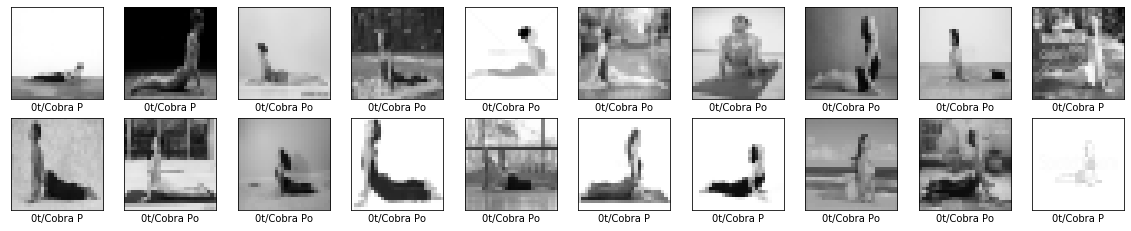

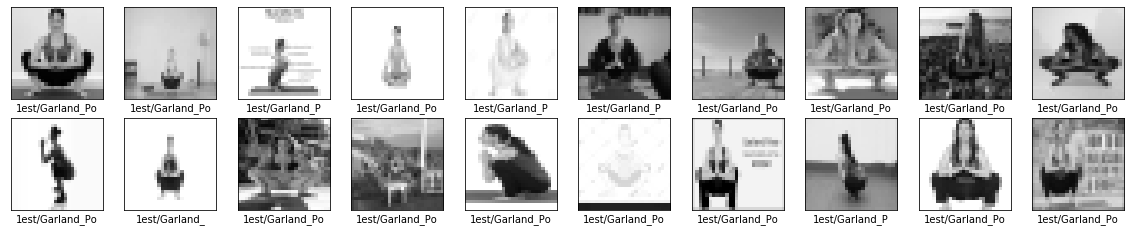

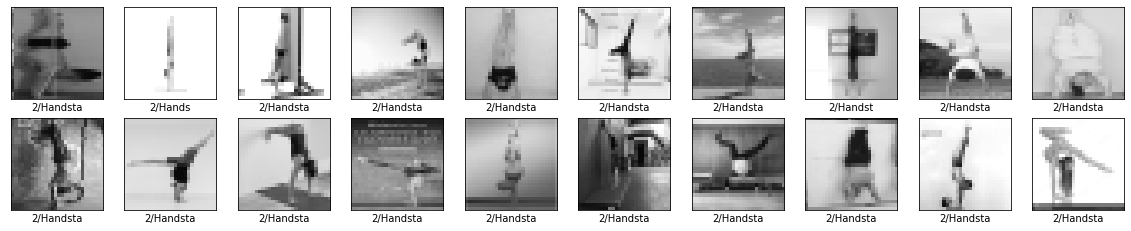

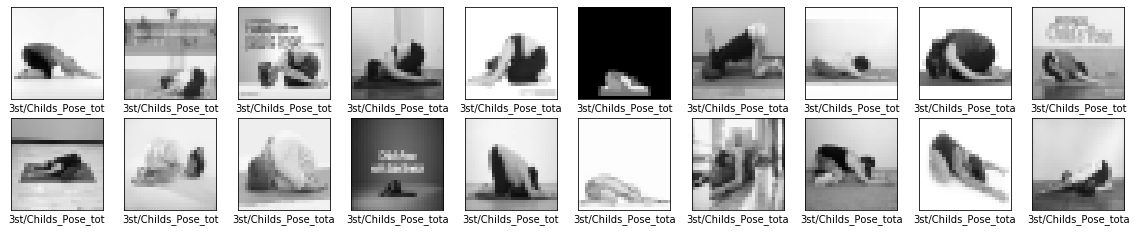

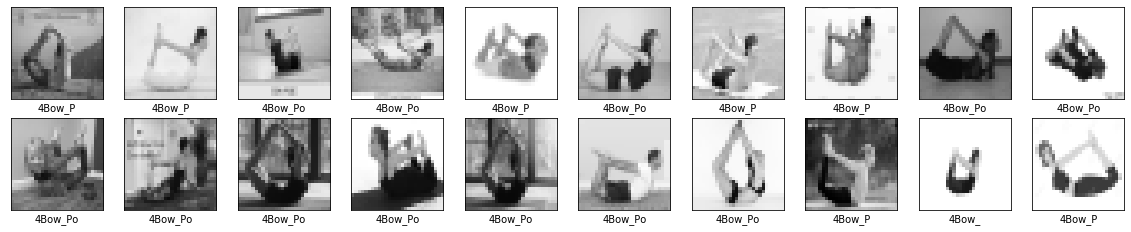

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

In [51]:
checkImgSet("Training Samples", x_train, y_train, filename_train, 10, 20)
checkImgSet("Validation Samples", x_test, y_test, filename_test, 10, 20)

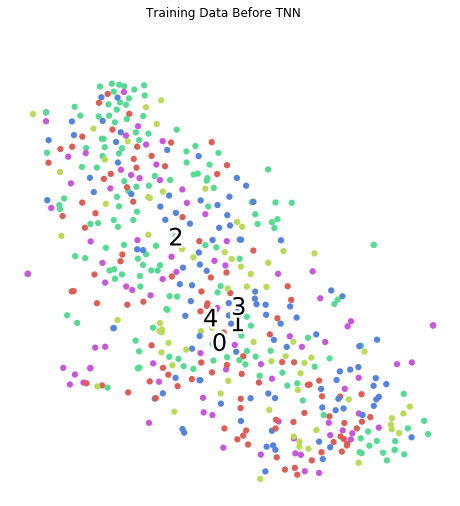

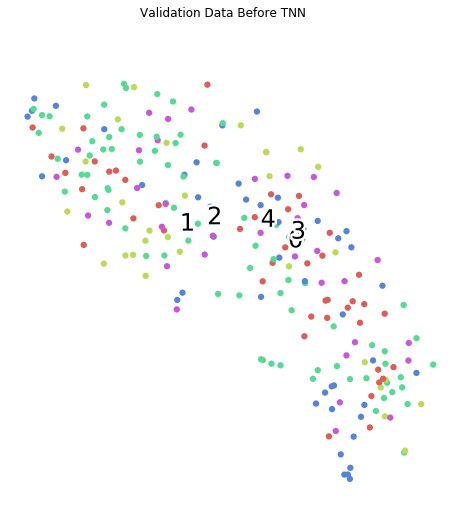

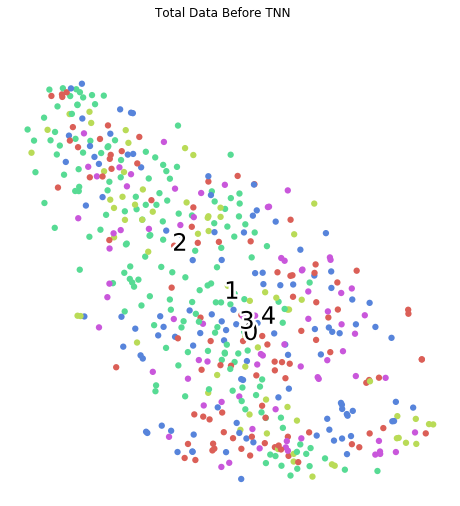

In [52]:
tsne = TSNE()
train_tsne_embeds = tsne.fit_transform(x_train_flat[:512])
eval_tsne_embeds = tsne.fit_transform(x_test_flat[:300])
total_tsne_embeds = tsne.fit_transform(x_total_flat[:512])
scatter(train_tsne_embeds, y_train[:512], 5, "Training Data Before TNN")
scatter(eval_tsne_embeds, y_test[:300], 5, "Validation Data Before TNN")
scatter(total_tsne_embeds, y_total[:512], 5, "Total Data Before TNN")



## Generate Triplet Data

In [53]:
def generate_triplet(x,y,testsize=0.3,ap_pairs=10,an_pairs=10):
    print(x.shape, y.shape)
    data_xy = tuple([x,y])
    print(data_xy[1].shape)
    
    trainsize = 1-testsize
    
    triplet_train_pairs = []
    triplet_test_pairs = []
    for data_class in sorted(set(data_xy[1])):
        same_class_idx = np.where(data_xy[1] == data_class)[0]
        diff_class_idx = np.where(data_xy[1] != data_class)[0]
        
        # num of each: ap_pairs, an_pairs
        A_P_pairs = random.sample(list(permutations(same_class_idx,2)),k=ap_pairs) #Generating Anchor-Positive pairs
        Neg_idx = random.sample(list(diff_class_idx),k=an_pairs)
        
        #total data: ap_pairs*an_pairs
        A_P_len = len(A_P_pairs)
        Neg_len = len(Neg_idx)
        
        for ap in A_P_pairs[:int(A_P_len*trainsize)]:
            Anchor = data_xy[0][ap[0]]
            Positive = data_xy[0][ap[1]]
            for n in Neg_idx:
                Negative = data_xy[0][n]
                triplet_train_pairs.append([Anchor,Positive,Negative])
                
        #test
        for ap in A_P_pairs[int(A_P_len*trainsize):]:
            Anchor = data_xy[0][ap[0]]
            Positive = data_xy[0][ap[1]]
            for n in Neg_idx:
                Negative = data_xy[0][n]
                triplet_test_pairs.append([Anchor,Positive,Negative])    
                
    return np.array(triplet_train_pairs), np.array(triplet_test_pairs)

In [54]:
def generate_triplet_2(x,y,testsize=0.3,ap_pairs=10,an_pairs=10):
    print(x.shape, y.shape)
    data_xy = tuple([x,y])
    print(data_xy[1].shape)
    
    trainsize = 1-testsize
    
    triplet_train_pairs = []
    triplet_test_pairs = []
    for data_class in sorted(set(data_xy[1])):
        same_class_idx = np.where(data_xy[1] == data_class)[0]
        diff_class_idx = np.where(data_xy[1] != data_class)[0]
        
        # num of each: ap_pairs, an_pairs
        A_P_pairs = random.sample(list(permutations(same_class_idx,2)),k=ap_pairs) #Generating Anchor-Positive pairs
        Neg_idx = random.sample(list(diff_class_idx),k=an_pairs)
        
        #total data: ap_pairs*an_pairs
        A_P_len = len(A_P_pairs)
        Neg_len = len(Neg_idx)
        ng_idx=0
        
        for ap in A_P_pairs[:int(A_P_len*trainsize)]:
            Anchor = data_xy[0][ap[0]]
            Positive = data_xy[0][ap[1]]
            Negative = data_xy[0][Neg_idx[ng_idx%Neg_len]]
            triplet_train_pairs.append([Anchor,Positive,Negative])
            ng_idx+=1
            
        #test
        for ap in A_P_pairs[int(A_P_len*trainsize):]:
            Anchor = data_xy[0][ap[0]]
            Positive = data_xy[0][ap[1]]
            Negative = data_xy[0][Neg_idx[ng_idx%Neg_len]]
            triplet_test_pairs.append([Anchor,Positive,Negative])
            ng_idx+=1
                
    return np.array(triplet_train_pairs), np.array(triplet_test_pairs)

In [55]:
def generate_triplet_all(x,y,testsize=0.3):
    print(x.shape, y.shape)
    data_xy = tuple([x,y])
    print(data_xy[1].shape)
    
    trainsize = 1-testsize
    
    triplet_train_pairs = []
    triplet_test_pairs = []
    for data_class in sorted(set(data_xy[1])):
        same_class_idx = np.where(data_xy[1] == data_class)[0]
        diff_class_idx = np.where(data_xy[1] != data_class)[0]
        
        # num of each: ap_pairs, an_pairs
        A_P_pairs = list(permutations(same_class_idx,2)) #Generating Anchor-Positive pairs
        Neg_idx = list(diff_class_idx)

        #total data: ap_pairs*an_pairs
        A_P_len = len(A_P_pairs)
        Neg_len = len(Neg_idx)
        ng_idx=0
        
        #train
        for ap in A_P_pairs[:int(A_P_len*trainsize)]:
            Anchor = data_xy[0][ap[0]]
            Positive = data_xy[0][ap[1]]
            Negative = data_xy[0][Neg_idx[ng_idx%Neg_len]]
            triplet_train_pairs.append([Anchor,Positive,Negative])
            ng_idx+=1
            
        #test
        for ap in A_P_pairs[int(A_P_len*trainsize):]:
            Anchor = data_xy[0][ap[0]]
            Positive = data_xy[0][ap[1]]
            Negative = data_xy[0][Neg_idx[ng_idx%Neg_len]]
            triplet_test_pairs.append([Anchor,Positive,Negative])
            ng_idx+=1  
                
    return np.array(triplet_train_pairs), np.array(triplet_test_pairs)

In [56]:
# total triplet data set: class * ap_pairs * an_pairs
# divide it to two data set with scaling (1-test_size, test_size)
#x_train_triplet, x_test_triplet = generate_triplet(x_train_flat,y_train, ap_pairs=150, an_pairs=150,testsize=0.2)
#x_train_triplet, x_test_triplet = generate_triplet_2(x_train_flat,y_train, ap_pairs=150*150, an_pairs=150,testsize=0.2)
#x_train_triplet, x_test_triplet = generate_triplet_all(x_train_flat,y_train,testsize=0.2)
x_train_triplet, x_test_triplet = generate_triplet_all(x_total_flat,y_total,testsize=0.2)


print(x_train_triplet.shape, x_test_triplet.shape)
#checkTripletImgSet("Training Samples", x_train_triplet,20)

(1645, 784) (1645,)
(1645,)
(485337, 3, 784) (121335, 3, 784)


## Base Network and Triplet NN

In [57]:
def create_base_network(in_dims):
    
    model = Sequential()
    model.add(Conv2D(128,(7,7),padding='same',input_shape=(in_dims[0],in_dims[1],in_dims[2],),activation='relu',name='conv1'))
    model.add(MaxPooling2D((2,2),(2,2),padding='same',name='pool1'))
    model.add(Conv2D(256,(5,5),padding='same',activation='relu',name='conv2'))
    model.add(MaxPooling2D((2,2),(2,2),padding='same',name='pool2'))
    model.add(Flatten(name='flatten'))
    model.add(Dense(4,name='embeddings'))
    return model

In [58]:
def triplet_loss(y_true, y_pred, alpha = MARGIN):
    
    print('y_pred.shape = ',y_pred)
    
    total_lenght = y_pred.shape.as_list()[-1]
#     print('total_lenght=',  total_lenght)
#     total_lenght =12
    
    anchor = y_pred[:,0:int(total_lenght*1/3)]
    positive = y_pred[:,int(total_lenght*1/3):int(total_lenght*2/3)]
    negative = y_pred[:,int(total_lenght*2/3):int(total_lenght*3/3)]

    # distance between the anchor and the positive
    pos_dist = K.sum(K.square(anchor-positive),axis=1)

    # distance between the anchor and the negative
    neg_dist = K.sum(K.square(anchor-negative),axis=1)

    # compute loss
    basic_loss = pos_dist-neg_dist+alpha
    loss = K.maximum(basic_loss,0.0)
 
    return loss

## Training for all cases

In [ ]:

for MARGIN in [1.1, 1.2, 1.3, 1.4]:
    for LEARNING_RATE in [0.001, 0.0005, 0.0001, 0.00005, 0.00001]:
        #---------------------------------------------------------------------------------------------------
        adam_optim = Adam(lr=LEARNING_RATE, beta_1=0.9, beta_2=0.999)
        #---------------------------------------------------------------------------------------------------
        input_row=28
        input_column=28
        input_channel=1
        anchor_input = Input((input_row, input_column, input_channel, ), name='anchor_input')
        positive_input = Input((input_row, input_column, input_channel, ), name='positive_input')
        negative_input = Input((input_row, input_column, input_channel, ), name='negative_input')

        # Shared embedding layer for positive and negative items
        Shared_DNN = create_base_network([input_row, input_column, input_channel,])


        encoded_anchor = Shared_DNN(anchor_input)
        encoded_positive = Shared_DNN(positive_input)
        encoded_negative = Shared_DNN(negative_input)


        merged_vector = concatenate([encoded_anchor, encoded_positive, encoded_negative], axis=-1, name='merged_layer')

        model = Model(inputs=[anchor_input,positive_input, negative_input], outputs=merged_vector)
        #---------------------------------------------------------------------------------------------------
        model.compile(loss=triplet_loss, optimizer=adam_optim)
        model.summary()
        #---------------------------------------------------------------------------------------------------
        Anchor = x_train_triplet[:,0,:].reshape(-1,input_row, input_column, input_channel)
        Positive = x_train_triplet[:,1,:].reshape(-1,input_row, input_column, input_channel)
        Negative = x_train_triplet[:,2,:].reshape(-1,input_row, input_column, input_channel)

        Anchor_test = x_test_triplet[:,0,:].reshape(-1,input_row, input_column, input_channel)
        Positive_test = x_test_triplet[:,1,:].reshape(-1,input_row, input_column, input_channel)
        Negative_test = x_test_triplet[:,2,:].reshape(-1,input_row, input_column, input_channel)


        Y_dummy = np.empty((Anchor.shape[0],300))
        Y_dummy2 = np.empty((Anchor_test.shape[0],1))
        #---------------------------------------------------------------------------------------------------
        #model.fit([Anchor,Positive,Negative],y=Y_dummy,validation_data=([Anchor_test,Positive_test,Negative_test],Y_dummy2), batch_size=512, epochs=500)
        #model.fit([Anchor,Positive,Negative],y=Y_dummy,validation_data=([Anchor_test,Positive_test,Negative_test],Y_dummy2), batch_size=512, epochs=20)
        MODEL_SAVE_FOLDER_PATH = './Presentation_Files/'
        LOG_SAVE_FOLDER_PATH = './Presentation_Files/'
        model_path = MODEL_SAVE_FOLDER_PATH + str(LEARNING_RATE+MARGIN)+'-{val_loss:.4f}-{epoch:02d}.hdf5'
        log_path = LOG_SAVE_FOLDER_PATH + str(LEARNING_RATE+MARGIN)+'-log.csv'

        csv_logger = CSVLogger(log_path, append=True, separator=';')
        cb_early_stopping = EarlyStopping(monitor='val_loss', patience=10)
        cb_checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_loss', verbose=1, save_best_only=True)
        model_history= model.fit([Anchor,Positive,Negative],y=Y_dummy,validation_data=([Anchor_test,Positive_test,Negative_test],Y_dummy2), batch_size=2048, epochs=100, callbacks=[csv_logger,cb_early_stopping,cb_checkpoint])
        #---------------------------------------------------------------------------------------------------
        model_json = model.to_json()
        with open(MODEL_SAVE_FOLDER_PATH + str(LEARNING_RATE+MARGIN), "w") as json_file : 
            json_file.write(model_json)

        model.save_weights(MODEL_SAVE_FOLDER_PATH + str(LEARNING_RATE+MARGIN)+".h5")
        print("Saved model to disk")


y_pred.shape =  Tensor("merged_layer_28/concat:0", shape=(?, 12), dtype=float32)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
anchor_input (InputLayer)       (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
positive_input (InputLayer)     (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
negative_input (InputLayer)     (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
sequential_29 (Sequential)      (None, 4)            876036      anchor_input[0][0]               
                            

485337/485337 [==============================] - 56s 116us/step - loss: 0.0981 - val_loss: 0.2106

Epoch 00003: val_loss improved from 0.46734 to 0.21057, saving model to ./Presentation_Files/1.1005-0.2106-03.hdf5
Epoch 4/100
485337/485337 [==============================] - 58s 119us/step - loss: 0.0232 - val_loss: 0.1218

Epoch 00004: val_loss improved from 0.21057 to 0.12182, saving model to ./Presentation_Files/1.1005-0.1218-04.hdf5
Epoch 5/100
485337/485337 [==============================] - 57s 117us/step - loss: 0.0078 - val_loss: 0.0759

Epoch 00005: val_loss improved from 0.12182 to 0.07589, saving model to ./Presentation_Files/1.1005-0.0759-05.hdf5
Epoch 6/100
485337/485337 [==============================] - 56s 116us/step - loss: 0.0040 - val_loss: 0.0610

Epoch 00006: val_loss improved from 0.07589 to 0.06101, saving model to ./Presentation_Files/1.1005-0.0610-06.hdf5
Epoch 7/100
485337/485337 [==============================] - 56s 116us/step - loss: 0.0023 - val_loss: 0.054

485337/485337 [==============================] - 60s 123us/step - loss: 5.7658 - val_loss: 1.5564

Epoch 00001: val_loss improved from inf to 1.55637, saving model to ./Presentation_Files/1.1000500000000002-1.5564-01.hdf5
Epoch 2/100
485337/485337 [==============================] - 57s 117us/step - loss: 0.5454 - val_loss: 0.6450

Epoch 00002: val_loss improved from 1.55637 to 0.64501, saving model to ./Presentation_Files/1.1000500000000002-0.6450-02.hdf5
Epoch 3/100
485337/485337 [==============================] - 57s 118us/step - loss: 0.1291 - val_loss: 0.2794

Epoch 00003: val_loss improved from 0.64501 to 0.27942, saving model to ./Presentation_Files/1.1000500000000002-0.2794-03.hdf5
Epoch 4/100
485337/485337 [==============================] - 57s 118us/step - loss: 0.0356 - val_loss: 0.1583

Epoch 00004: val_loss improved from 0.27942 to 0.15831, saving model to ./Presentation_Files/1.1000500000000002-0.1583-04.hdf5
Epoch 5/100
485337/485337 [==============================] - 57s


Epoch 00006: val_loss improved from 0.58314 to 0.41903, saving model to ./Presentation_Files/1.1000100000000002-0.4190-06.hdf5
Epoch 7/100
485337/485337 [==============================] - 56s 116us/step - loss: 0.0799 - val_loss: 0.3133

Epoch 00007: val_loss improved from 0.41903 to 0.31328, saving model to ./Presentation_Files/1.1000100000000002-0.3133-07.hdf5
Epoch 8/100
485337/485337 [==============================] - 57s 117us/step - loss: 0.0448 - val_loss: 0.2262

Epoch 00008: val_loss improved from 0.31328 to 0.22618, saving model to ./Presentation_Files/1.1000100000000002-0.2262-08.hdf5
Epoch 9/100
485337/485337 [==============================] - 56s 116us/step - loss: 0.0256 - val_loss: 0.1757

Epoch 00009: val_loss improved from 0.22618 to 0.17574, saving model to ./Presentation_Files/1.1000100000000002-0.1757-09.hdf5
Epoch 10/100
485337/485337 [==============================] - 57s 117us/step - loss: 0.0151 - val_loss: 0.1421

Epoch 00010: val_loss improved from 0.17574 to

In [30]:
#adam_optim = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999)
adam_optim = Adam(lr=LEARNING_RATE, beta_1=0.9, beta_2=0.999)

In [31]:
input_row=28
input_column=28
input_channel=1
anchor_input = Input((input_row, input_column, input_channel, ), name='anchor_input')
positive_input = Input((input_row, input_column, input_channel, ), name='positive_input')
negative_input = Input((input_row, input_column, input_channel, ), name='negative_input')

# Shared embedding layer for positive and negative items
Shared_DNN = create_base_network([input_row, input_column, input_channel,])


encoded_anchor = Shared_DNN(anchor_input)
encoded_positive = Shared_DNN(positive_input)
encoded_negative = Shared_DNN(negative_input)


merged_vector = concatenate([encoded_anchor, encoded_positive, encoded_negative], axis=-1, name='merged_layer')

model = Model(inputs=[anchor_input,positive_input, negative_input], outputs=merged_vector)


In [32]:
model.compile(loss=triplet_loss, optimizer=adam_optim)
model.summary()

y_pred.shape =  Tensor("merged_layer_1/concat:0", shape=(?, 12), dtype=float32)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
anchor_input (InputLayer)       (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
positive_input (InputLayer)     (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
negative_input (InputLayer)     (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 4)            876036      anchor_input[0][0]               
                             

## Training Triplet NN

In [33]:
#model.load_weights('test_models/test_model_3.h5')

In [34]:
Anchor = x_train_triplet[:,0,:].reshape(-1,input_row, input_column, input_channel)
Positive = x_train_triplet[:,1,:].reshape(-1,input_row, input_column, input_channel)
Negative = x_train_triplet[:,2,:].reshape(-1,input_row, input_column, input_channel)

Anchor_test = x_test_triplet[:,0,:].reshape(-1,input_row, input_column, input_channel)
Positive_test = x_test_triplet[:,1,:].reshape(-1,input_row, input_column, input_channel)
Negative_test = x_test_triplet[:,2,:].reshape(-1,input_row, input_column, input_channel)


Y_dummy = np.empty((Anchor.shape[0],300))
Y_dummy2 = np.empty((Anchor_test.shape[0],1))



In [35]:
#model.fit([Anchor,Positive,Negative],y=Y_dummy,validation_data=([Anchor_test,Positive_test,Negative_test],Y_dummy2), batch_size=512, epochs=500)
#model.fit([Anchor,Positive,Negative],y=Y_dummy,validation_data=([Anchor_test,Positive_test,Negative_test],Y_dummy2), batch_size=512, epochs=20)
MODEL_SAVE_FOLDER_PATH = './Presentation_Files/'
LOG_SAVE_FOLDER_PATH = './Presentation_Files/'
model_path = MODEL_SAVE_FOLDER_PATH + str(LEARNING_RATE+MARGIN)+'-{val_loss:.4f}-{epoch:02d}.hdf5'
log_path = LOG_SAVE_FOLDER_PATH + str(LEARNING_RATE+MARGIN)+'-log.csv'

csv_logger = CSVLogger(log_path, append=True, separator=';')
cb_early_stopping = EarlyStopping(monitor='val_loss', patience=10)
cb_checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_loss', verbose=1, save_best_only=True)
model_history= model.fit([Anchor,Positive,Negative],y=Y_dummy,validation_data=([Anchor_test,Positive_test,Negative_test],Y_dummy2), batch_size=2048, epochs=100, callbacks=[csv_logger,cb_early_stopping,cb_checkpoint])



Train on 485337 samples, validate on 121335 samples
Epoch 1/100
485337/485337 [==============================] - 58s 118us/step - loss: 17.1595 - val_loss: 0.7921

Epoch 00001: val_loss improved from inf to 0.79208, saving model to ./Presentation_Files/1.3005-0.7921-01.hdf5
Epoch 2/100
485337/485337 [==============================] - 57s 117us/step - loss: 0.3909 - val_loss: 0.3827

Epoch 00002: val_loss improved from 0.79208 to 0.38268, saving model to ./Presentation_Files/1.3005-0.3827-02.hdf5
Epoch 3/100
485337/485337 [==============================] - 57s 118us/step - loss: 0.1339 - val_loss: 0.2093

Epoch 00003: val_loss improved from 0.38268 to 0.20929, saving model to ./Presentation_Files/1.3005-0.2093-03.hdf5
Epoch 4/100
485337/485337 [==============================] - 56s 116us/step - loss: 0.0436 - val_loss: 0.1158

Epoch 00004: val_loss improved from 0.20929 to 0.11583, saving model to ./Presentation_Files/1.3005-0.1158-04.hdf5
Epoch 5/100
485337/485337 [====================

KeyboardInterrupt: 

In [ ]:
model_json = model.to_json()
with open("models/yoga_model_001", "w") as json_file : 
    json_file.write(model_json)
    
model.save_weights("models/yoga_model_001.h5")
print("Saved model to disk")

In [ ]:
trained_model = Model(inputs=anchor_input, outputs=encoded_anchor)
trained_model.load_weights('models/yoga_model.h5')

In [ ]:
plt.figure(figsize=(8,8))
plt.plot(model_history.history['loss'], label='training loss')
plt.plot(model_history.history['val_loss'], label='validation loss')
plt.legend()
plt.title('Train/validation loss')
plt.show()

## Convert img to 2D-point (x,y)
1. Convert img to vector value via Triplet NN
2. Lower the dimension of vector value via TSNE

In [ ]:
#x_train_trm = trained_model.predict(x_train.reshape(-1, input_row, input_column, input_channel))
#x_test_trm = trained_model.predict(x_test.reshape(-1, input_row, input_column, input_channel))
x_total_trm = trained_model.predict(x_total.reshape(-1, input_row, input_column, input_channel))

In [ ]:

tsne = TSNE()
#raw_train_tsne_embeds = tsne.fit_transform(x_train_flat[:512])
#raw_eval_tsne_embeds = tsne.fit_transform(x_test_flat)
#train_tsne_embeds = tsne.fit_transform(x_train_trm[:512])
#eval_tsne_embeds = tsne.fit_transform(x_test_trm)
total_tsne_embeds = tsne.fit_transform(x_total_trm)

## Plotting Points

In [ ]:
'''
scatter(raw_train_tsne_embeds, y_train[:512], 5, "Training Data Before TNN")
scatter(raw_eval_tsne_embeds, y_test, 5, "Validation Data Before TNN")
scatter(train_tsne_embeds, y_train[:512], 5, "Training Data After TNN")
scatter(eval_tsne_embeds, y_test, 5, "Validation Data After TNN")
'''
scatter(total_tsne_embeds, y_total, 5, "total data after TNN")

## Add Clustering Module: Annoy

In [ ]:
data_frame=[]
img_dict={}
for idx in range(len(y_total)):
    data_frame.append({'filename':filename_total[idx], 'category':y_total[idx]})
    img_dict[idx]=x_total_trm[idx]


In [ ]:
for idx in range(50):
    print(data_frame[idx], img_dict[idx])

## Annoy Model

In [6]:
from annoy import AnnoyIndex
import random
import pandas as pd

In [7]:
dimension=4
ann_sample = AnnoyIndex(dimension, 'euclidean')

for i in range(len(data_frame)):
    #v = [random.gauss(0,1) for z in range(f)]
    ann_sample.add_item(i,img_dict[i])
ann_sample.build(10)
ann_sample.save('test.ann')   
data_frame_pd = pd.DataFrame(data_frame)
data_frame_pd.to_csv("data_frame.csv")

NameError: name 'data_frame' is not defined

In [38]:
data_frame_pd.head()

,filename,category
0,../../data/Handstand/train/Handstand_391.jpg,2
1,../../data/Handstand/train/Handstand_279.jpg,2
2,../../data/Cobra_Pose/train/Cobra Pose_486.jpg,0
3,../../data/Garland_Pose/train/Garland_Pose_355...,1
4,../../data/Cobra_Pose/train/Cobra Pose_67.jpg,0


In [8]:
ann_model=AnnoyIndex(dimension,'euclidean')
ann_model.load('test.ann')
data_frame_pd = pd.read_csv("data_frame.csv")
data_frame_label = data_frame_pd['category']

target_vector=img_dict[50]
nns_num=100
nns = ann_model.get_nns_by_vector(target_vector, nns_num)


NameError: name 'img_dict' is not defined

In [59]:
data_frame_label[nns].value_counts().argmax()


/home/ubuntu/anaconda3/envs/triplet36/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  """Entry point for launching an IPython kernel.


1

In [168]:
def get_label(filename):
    # load yoga model
    trained_model = Model(inputs=anchor_input, outputs=encoded_anchor)
    trained_model.load_weights('models/yoga_model.h5')
    
    # laod image and convert to 4-dimension
    row=28
    column=28
    channel=1
    img = cv2.imread(filename, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (row,column), interpolation = cv2.INTER_AREA)
    target_vector = trained_model.predict(img.reshape(-1, row, column, channel))
    
    # laod annoy model
    dimension=4
    ann_model=AnnoyIndex(dimension,'euclidean')
    ann_model.load('test.ann')
    data_frame_pd = pd.read_csv("data_frame.csv")
    data_frame_label = data_frame_pd['category']
    nns_num=100
    nns = ann_model.get_nns_by_vector(target_vector[0], nns_num)
    return target_vector, data_frame_label[nns].value_counts().argmax()


In [94]:
#get_label('../../data/Bow_Pose/test/Bow_Pose_0.jpg')


/home/ubuntu/anaconda3/envs/triplet36/lib/python3.6/site-packages/ipykernel_launcher.py:23: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.


4

In [96]:
#get_label('../../data/img.jpg')


/home/ubuntu/anaconda3/envs/triplet36/lib/python3.6/site-packages/ipykernel_launcher.py:23: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.


0

Validation Samples


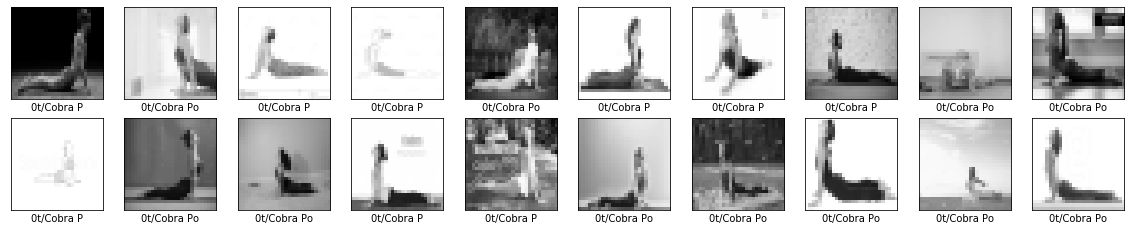

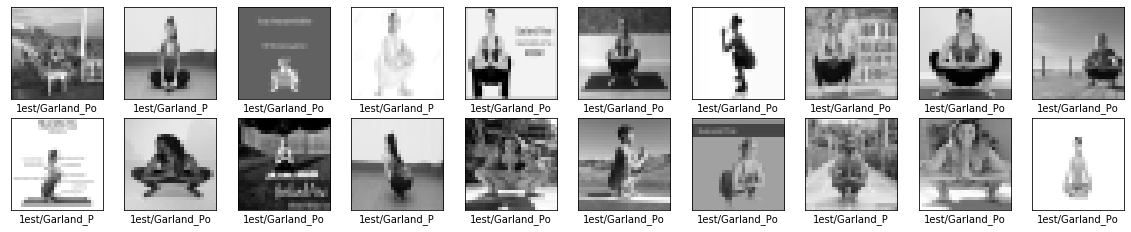

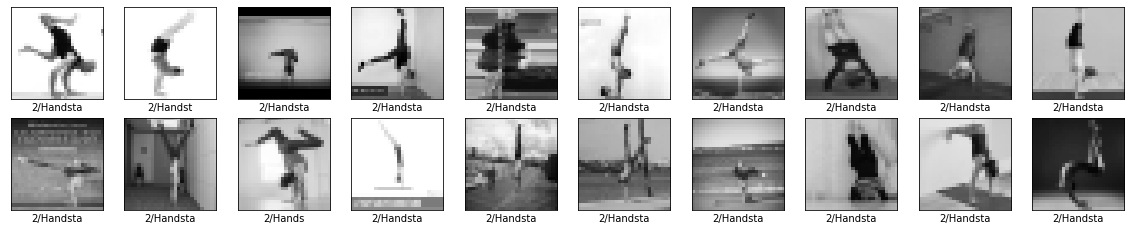

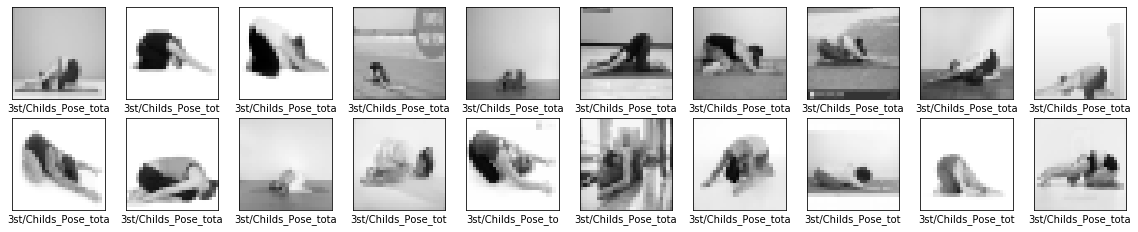

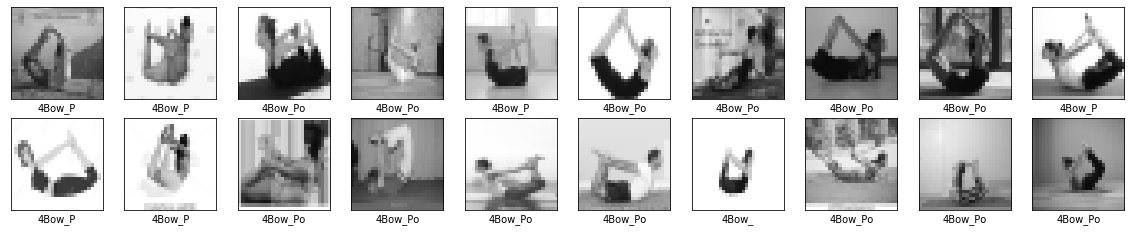

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

In [98]:
checkImgSet("Validation Samples", x_test, y_test, filename_test, 10, 20)

In [180]:
ivector, ilabel = get_label('../../data/img3.jpg')


x_total_trm = trained_model.predict(x_total.reshape(-1, input_row, input_column, input_channel))
idxs = [np.where(y_total==i) for i in range(5)]

total_x=np.array(ivector)
total_y=np.array([ilabel])
for i in range(5):
    #print(x_total_trm[idxs[i]][:100])
    #print(y_total[idxs[i]][:100])
    total_x = np.concatenate([total_x, x_total_trm[idxs[i]][:100]], axis=0)
    total_y = np.concatenate([total_y, y_total[idxs[i]][:100]],axis=0)
print(total_x)
print(total_y)

tsne_embeds = tsne.fit_transform(total_x)


/home/ubuntu/anaconda3/envs/triplet36/lib/python3.6/site-packages/ipykernel_launcher.py:23: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.


[[ 4.9066525  -0.49120533 -0.50397056  1.2730529 ]
 [ 4.818788    0.1650434   1.1249416   0.6884687 ]
 [ 5.8998246   1.2089504   1.2763177   2.3883402 ]
 ...
 [ 0.8157719  -1.5742959  -0.34528893  4.6357393 ]
 [ 0.7064741  -0.0763048   0.07289987  4.1705093 ]
 [ 1.854001   -1.9089062  -1.7169552   4.7700353 ]]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 

0


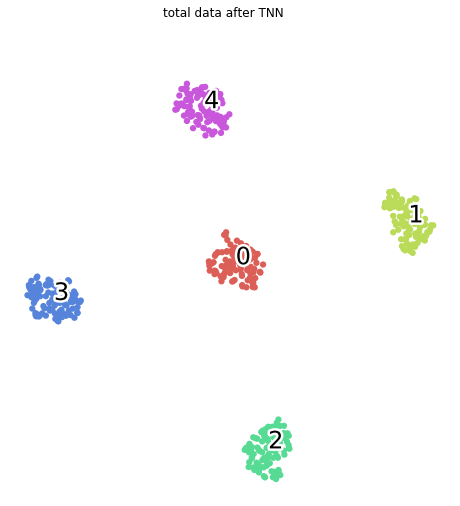

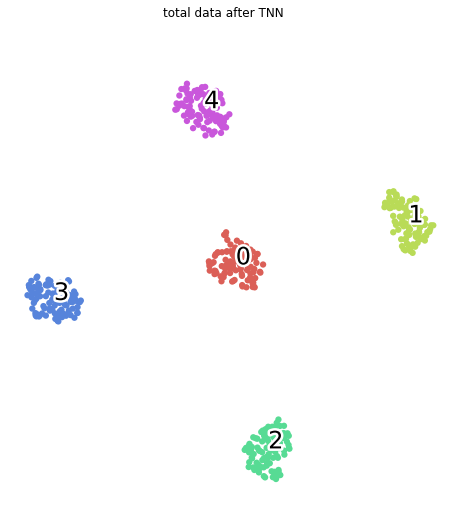

In [181]:
print(total_y[0])
scatter(tsne_embeds, total_y, 5, "total data after TNN")
scatter(tsne_embeds[1:], total_y[1:], 5, "total data after TNN")